Final Project 
======

Kaggle Competition 
-----

For this project I chose to do the active competition [San Francisco Crime Classification](https://www.kaggle.com/c/sf-crime/). I'll test out a number of different algorithms with test data. I am interested in this type of analysis as it is data science that contributes to the common good.

#### Import libraries

In [1]:
# Pandas and numpy
import pandas as pd
import numpy as np

# Python functions
from dateutil.relativedelta import *
from datetime import datetime

# Patsy 
from patsy import dmatrices

# sklearn functions
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.preprocessing import OneHotEncoder, Imputer
from sklearn.preprocessing import LabelEncoder, scale
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.feature_selection import SelectKBest,\
                        SelectPercentile, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.grid_search import GridSearchCV 
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import AdaBoostClassifier

# matplotlib 
import matplotlib.pyplot as plt
%matplotlib inline

# Make plots BIG
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 12, 8

# GIS functionality
from mpl_toolkits.basemap import Basemap, cm
import cartopy.io.shapereader as shpreader
import fiona
import pysal 
from pyproj import Proj
from pysal.cg.shapes import Point
from pysal.cg.locators import PolygonLocator, PointLocator, BruteForcePointLocator 
from pysal.cg.sphere import arcdist

In [2]:
class MultiColumnLabelEncoder:
    ''' Create a class that encodes
        labels for a matrix of data
    '''
    def __init__(self, columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here
    
    def get_params(self, deep=True):
        out = dict()
        if self.columns: out['columns'] = columns
        return out

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). 
        '''
        numerics = [np.float16, np.float32, np.float64]
        ints = [np.int16, np.int32, np.int64]
        output = X.copy()
        '''
        if self.columns is not None:
            for col in self.columns:
                if col.dtype not in numerics+ints:
                    output[col] = LabelEncoder().fit_transform(output[col])
                elif col.dtype not in ints:
                    output[col] = scale(output[col])
        else:
        '''
        try:
            for colname,col in output.iteritems():
                if col.dtype not in numerics+ints:
                    output[colname] = LabelEncoder().fit_transform(output[colname])
                elif col.dtype not in ints:
                    output[colname] = scale(output[colname])
        except:
            output = LabelEncoder().fit_transform(output)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

#### Part 1 - Submit first (bad) try

In [4]:
train_raw = pd.read_csv('Data/train.csv')
test_raw = pd.read_csv('Data/test.csv')
sample_submission = pd.read_csv('Data/sampleSubmission.csv')
print train_raw.shape

(878049, 9)


In [4]:
train_raw.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541


In [4]:
test_raw.head()

,Id,Dates,DayOfWeek,PdDistrict,Address,X,Y
0,0,2015-05-10 23:59:00,Sunday,BAYVIEW,2000 Block of THOMAS AV,-122.399588,37.735051
1,1,2015-05-10 23:51:00,Sunday,BAYVIEW,3RD ST / REVERE AV,-122.391523,37.732432
2,2,2015-05-10 23:50:00,Sunday,NORTHERN,2000 Block of GOUGH ST,-122.426002,37.792212
3,3,2015-05-10 23:45:00,Sunday,INGLESIDE,4700 Block of MISSION ST,-122.437394,37.721412
4,4,2015-05-10 23:45:00,Sunday,INGLESIDE,4700 Block of MISSION ST,-122.437394,37.721412


In [5]:
sample_submission.head()

,Id,ARSON,ASSAULT,BAD CHECKS,BRIBERY,BURGLARY,DISORDERLY CONDUCT,DRIVING UNDER THE INFLUENCE,DRUG/NARCOTIC,DRUNKENNESS,...,SEX OFFENSES NON FORCIBLE,STOLEN PROPERTY,SUICIDE,SUSPICIOUS OCC,TREA,TRESPASS,VANDALISM,VEHICLE THEFT,WARRANTS,WEAPON LAWS
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [6]:
train_data\
,train_labels = train_raw[['DayOfWeek'\
                                     ,'PdDistrict'\
                                     ,'Address'\
                                     ,'X'\
                                     ,'Y']][2001:]\
                            ,train_raw['Category'][2001:]
dev_data\
,dev_labels = train_raw[['DayOfWeek'\
                                 ,'PdDistrict'\
                                 ,'Address'\
                                 ,'X'\
                                 ,'Y']][:1000]\
                            ,train_raw['Category'][:1000]
dev_test_data\
,dev_test_labels = train_raw[['DayOfWeek'\
                                 ,'PdDistrict'\
                                 ,'Address'\
                                 ,'X'\
                                 ,'Y']][1001:2000]\
                            ,train_raw['Category'][1001:2000]
test_data = test_raw[['DayOfWeek'\
                     ,'PdDistrict'\
                     ,'Address'\
                     ,'X'\
                     ,'Y']]

In [7]:
rf = RandomForestClassifier() #leaving with default settings for now

Data needs to be preprocessed for RF in sklearn

In [8]:
def recode(df):
    numerics = ['float16', 'float32', 'float64']
    ints = ['int16', 'int32', 'int64']
    for i in range(df.shape[1]):
        t = df.iloc[:,i].dtype
        if t not in numerics or ints:
            le = LabelEncoder()
            le.fit(df.iloc[:,i])
            df.iloc[:,i] = le.transform(df.iloc[:,i])
        elif t not in ints:
            df.iloc[:,i] = scale(df.iloc[:,i])
    return df

def recode_labels(df):
    le = LabelEncoder()
    le.fit(df)
    return le

In [9]:
dev_data = recode(dev_data)
dev_label_le = recode_labels(np.concatenate((dev_labels,dev_test_labels),axis=1))
dev_labels = dev_label_le.transform(dev_labels)
dev_test_data = recode(dev_test_data)
dev_test_labels = dev_label_le.transform(dev_test_labels)

Run model

In [10]:
rf.fit(dev_data,dev_labels)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [11]:
predictions = rf.predict(dev_test_data)

In [13]:
actual_predictions = dev_label_le.inverse_transform(predictions)
actual_labels = dev_label_le.inverse_transform(dev_test_labels)
print actual_predictions[:5],'\n',actual_labels[:5]

['LARCENY/THEFT' 'LARCENY/THEFT' 'SUSPICIOUS OCC' 'VEHICLE THEFT'
 'VEHICLE THEFT'] 
['OTHER OFFENSES' 'LARCENY/THEFT' 'LARCENY/THEFT' 'WARRANTS' 'WARRANTS']


In [14]:
accuracy = np.sum((actual_predictions == actual_labels)*1.0)/len(dev_labels)
print 'Dev Accuracy: {0}%'.format(accuracy*100)

Dev Accuracy: 21.6%


Train with real data

In [15]:
train_data, test_data = recode(train_data), recode(test_data)
train_le = recode_labels(train_labels)
train_labels = train_le.transform(train_labels)

/Library/Python/2.7/site-packages/pandas/core/indexing.py:415: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [16]:
rf = RandomForestClassifier()
rf.fit(train_data, train_labels)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Make predictions and reformat for submission

In [17]:
predictions = rf.predict(test_data)
actual_predictions = train_le.inverse_transform(predictions)

In [18]:
l = len(test_data)
submission = np.zeros((l,40),dtype=np.int32)
submission[:,0] = range(l)
cols = train_le.classes_ 
for i,c in enumerate(cols):
    submission[:,i+1] = actual_predictions == c

In [19]:
submission_cols = ['Id']
submission_cols.extend(cols)
submission_df = pd.DataFrame(submission,columns=submission_cols)
submission_df.head()

,Id,ARSON,ASSAULT,BAD CHECKS,BRIBERY,BURGLARY,DISORDERLY CONDUCT,DRIVING UNDER THE INFLUENCE,DRUG/NARCOTIC,DRUNKENNESS,...,SEX OFFENSES NON FORCIBLE,STOLEN PROPERTY,SUICIDE,SUSPICIOUS OCC,TREA,TRESPASS,VANDALISM,VEHICLE THEFT,WARRANTS,WEAPON LAWS
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Save data to csv file for submission

In [20]:
# submission_df.to_csv('Data/submission_file1.csv',index=False)

First attempt: Rank 208, score 26.95890, tested accuracy of ~20-23%.

##### See where model breaks down

In [21]:
dev_test_data\
,dev_test_labels = train_raw[['DayOfWeek'\
                                 ,'PdDistrict'\
                                 ,'Address'\
                                 ,'X'\
                                 ,'Y']][1001:2000]\
                            ,train_raw['Category'][1001:2000]
dev_test_data = recode(dev_test_data)
predictions = rf.predict(dev_test_data)
actual_predictions = train_le.inverse_transform(predictions)

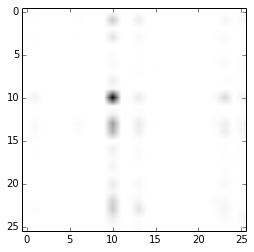

In [22]:
conf = confusion_matrix(dev_test_labels,actual_predictions)
plt.imshow(conf, cmap='binary')

In [23]:
pd.crosstab(dev_test_labels, actual_predictions, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,ASSAULT,DRUG/NARCOTIC,LARCENY/THEFT,MISSING PERSON,NON-CRIMINAL,OTHER OFFENSES,RECOVERED VEHICLE,VANDALISM,VEHICLE THEFT,WEAPON LAWS,All
True,,,,,,,,,,,
ARSON,0,1,2,0,0,0,0,1,0,0,4
ASSAULT,2,2,44,0,16,0,0,0,8,7,79
BRIBERY,0,0,1,0,0,0,0,0,0,0,1
BURGLARY,2,1,23,0,6,1,0,2,4,0,39
DISORDERLY CONDUCT,0,0,0,0,1,0,0,0,1,0,2
DRIVING UNDER THE INFLUENCE,0,0,3,0,1,0,0,1,1,0,6
DRUG/NARCOTIC,0,1,5,0,1,0,0,2,4,4,17
DRUNKENNESS,0,0,1,0,2,0,1,0,0,1,5
FRAUD,0,1,15,1,0,0,0,0,2,2,21


Since samples are not weighted well in terms of categories, the model seems to be having difficulties with categories that have a larger amount of observations - likely because all of the conditions used to predict crimes are seen more frequently for the samples with more observations. To make the model generalize better, it will be necessary to resample the dataset so that possible outcomes are represented more evenly. 

#### Part 2 - Tests to increase accuracy

In [3]:
# Reload data - start from here 
train_raw = pd.read_csv('Data/train.csv')
test_raw = pd.read_csv('Data/test.csv')
sample_submission = pd.read_csv('Data/sampleSubmission.csv')
print train_raw.shape

(878049, 9)


##### Gather together cases that seem to be at same time/location or otherwise related
This did not have a positive effect on model - will probably remove

In [4]:
def gather_crimes(df):
    ''' Some crimes seem to be linked
        to each other 
        Group crimes in the same address
        within an hour of each other
    '''
    n = df.shape[0]
    out = np.zeros(n,dtype=np.int64)
    d_last = datetime(1970,1,1)
    addr_last = 'Unknown'
    x = 0
    for i in range(n):
        if i%100000==0: print 'Working row {0}'.format(i)
        d = df.iloc[i]['Dates']
        if d < d_last: raise Exception('Dates not sorted')
        addr = df.iloc[i]['Address']
        r = d+relativedelta(hours=-1)
        if r > d_last or addr_last!=addr: x+=1
        d_last = d
        addr_last = addr
        out[i] = x
    return out

def run_crimegrouping():
    train_raw['Dates'] = pd.to_datetime(train_raw['Dates'])
    test_raw['Dates'] = pd.to_datetime(test_raw['Dates'])
    train_raw = train_raw.sort(['Dates'],kind='mergesort')
    test_raw = test_raw.sort(['Dates'],kind='mergesort')
    train_raw['crime_groupid'] = gather_crimes(train_raw)
    test_raw['crime_groupid'] = gather_crimes(test_raw)
    train_raw.to_csv('Data/train_raw_wcrimegroup.csv',index=False)
    test_raw.to_csv('Data/test_raw_wcrimegroup.csv',index=False)

In [4]:
def collar_crimes(x):
    ''' Add a meta category for 
        crimes based on the skills
        required
    '''
    white_collar = [ "FRAUD"
                   , "FORGERY/COUNTERFEITING"
                   , "BAD CHECKS" 
                   , "EXTORTION"
                   , "EMBEZZLEMENT"
                   , "SUSPICIOUS OCC"
                   , "BRIBERY"]
    blue_collar_violent = [ 
                   "ASSAULT"
                   , "KIDNAPPING"
                   , "ARSON"
                   , 'FAMILY OFFENSES'
                   , 'SECONDARY CODES'
                  ]
    blue_collar_other = [
                "VANDALISM"
                ,"DISORDERLY CONDUCT"
                , "TRESPASS"
                , 'TREA'
    ]
    sex_crimes = [
            'SEX OFFENSES FORCIBLE',
            'PORNOGRAPHY/OBSCENE MAT',
            'SEX OFFENSES NON FORCIBLE',
            'PROSTITUTION'
        ]
    drug_alcohol = [
        'DRIVING UNDER THE INFLUENCE',
        'DRUNKENNESS',
        'DRUG/NARCOTIC',
        'LIQUOR LAWS'
    ]
    theft = [
        'LARCENY/THEFT',
         'VEHICLE THEFT',
         'STOLEN PROPERTY',
         "ROBBERY"
    ]
    non_criminal = [
        'RECOVERED VEHICLE',
        'NON-CRIMINAL',
        'MISSING PERSON',
        'RUNAWAY',
        'SUICIDE',
        'SUSPICIOUS OCC',
        'LOITERING',
        "RECOVERED VEHICLE"
    ]
    if x in white_collar: return 1
    elif x in blue_collar_violent: return 2
    elif x in blue_collar_other: return 3
    elif x in sex_crimes: return 4
    elif x in drug_alcohol: return 5
    elif x in theft: return 6
    elif x in non_criminal: return 7
    else: return 8
collar_crimes = np.vectorize(collar_crimes,otypes=[np.int64])
train_raw['collar_id'] = collar_crimes(train_raw['Category'])

Since we don't have crime category in the final set of data, test out prediction of metaclass within training set

In [5]:
def make_classweights():
    g = train_raw.groupby('Category')
    class_weights = np.sqrt(np.mean(g['Category'].agg(len))/g['Category'].agg(len))
    class_weights_df = pd.DataFrame({'Category':class_weights.index.values,'Weight':class_weights.values})
    train_raw['sample_weight'] = pd.merge(train_raw,class_weights_df,on=['Category'])['Weight']
    print class_weights
    return class_weights

class_weights = make_classweights()

Category
ARSON                           3.857515
ASSAULT                         0.541167
BAD CHECKS                      7.446703
BRIBERY                         8.826289
BURGLARY                        0.782652
DISORDERLY CONDUCT              2.282891
DRIVING UNDER THE INFLUENCE     3.150689
DRUG/NARCOTIC                   0.645873
DRUNKENNESS                     2.293534
EMBEZZLEMENT                    4.394180
EXTORTION                       9.377932
FAMILY OFFENSES                 6.771523
FORGERY/COUNTERFEITING          1.456766
FRAUD                           1.161829
GAMBLING                       12.417971
KIDNAPPING                      3.101176
LARCENY/THEFT                   0.358783
LIQUOR LAWS                     3.439598
LOITERING                       4.287055
MISSING PERSON                  0.930748
NON-CRIMINAL                    0.493875
OTHER OFFENSES                  0.422404
PORNOGRAPHY/OBSCENE MAT        31.990110
PROSTITUTION                    1.734444
RECOVER

In [6]:
def sample_df(df,group_name,groups,group_n):
    ''' Since sample weighting 
        doesn't seem to work properly,
        instead do sampling manually with 
        even group size 
    '''
    x = df.copy()
    out = []
    for g in groups:
        try:
            # Replace only when necessary
            out.append(x[x[group_name]==g].\
                   sample(group_n,replace=False))
        except:
            n = len(x[x[group_name]==g])
            out.append(x[x[group_name]==g])
            out.append(x[x[group_name]==g].\
                   sample(group_n-n,replace=True))
    out_df = pd.concat(out)
    s = out_df.sample(group_n*len(groups)\
                      ,replace=True)
    return s
        
z = sample_df(train_raw,'Category',set(train_raw['Category']),\
                                      group_n=1000)
g = z.groupby(['Category'])['Category'].agg(len)
print g

Category
ARSON                           989
ASSAULT                         977
BAD CHECKS                     1001
BRIBERY                         998
BURGLARY                        983
DISORDERLY CONDUCT             1021
DRIVING UNDER THE INFLUENCE    1000
DRUG/NARCOTIC                  1022
DRUNKENNESS                     983
EMBEZZLEMENT                   1049
EXTORTION                      1057
FAMILY OFFENSES                1044
FORGERY/COUNTERFEITING          958
FRAUD                           947
GAMBLING                        942
KIDNAPPING                      987
LARCENY/THEFT                  1037
LIQUOR LAWS                     954
LOITERING                      1013
MISSING PERSON                  965
NON-CRIMINAL                   1006
OTHER OFFENSES                  995
PORNOGRAPHY/OBSCENE MAT        1006
PROSTITUTION                   1002
RECOVERED VEHICLE              1076
ROBBERY                         982
RUNAWAY                         986
SECONDARY CODES    

##### Add time of day 

In [7]:
def segment_time1(ts):
    ''' Segment time of day '''
    if ts.hour<=4: return 1
    elif ts.hour<=8: return 2
    elif ts.hour<=12: return 3
    elif ts.hour<=16: return 4
    elif ts.hour<=20: return 5
    elif ts.hour<=24: return 6
def segment_time2(ts):
    ''' Return only hour '''
    return ts.hour
def dayofmonth(ts):
    ''' Return day of month '''
    return ts.day
def yearofcrime(ts):
    ''' Return the year '''
    return ts.year

train_raw['Dates'] = pd.to_datetime(train_raw['Dates'])
test_raw['Dates'] = pd.to_datetime(test_raw['Dates'])

train_raw['DaySegment'] = train_raw['Dates'].apply(segment_time1)
test_raw['DaySegment'] = test_raw['Dates'].apply(segment_time1)

train_raw['TimeOfDay'] = train_raw['Dates'].apply(segment_time2)
test_raw['TimeOfDay'] = test_raw['Dates'].apply(segment_time2)

train_raw['DayOfMonth'] = train_raw['Dates'].apply(dayofmonth)
test_raw['DayOfMonth'] = test_raw['Dates'].apply(dayofmonth)

train_raw['Year'] = train_raw['Dates'].apply(yearofcrime)
test_raw['Year'] = test_raw['Dates'].apply(yearofcrime)

##### Add clustering based on lat/lon

Currently, by using the exact location of the crime, the model does not generalize very well. A couple options are available: 1) utilize publicly available datasets on city neighborhoods to classify each event into a more generalized city segment, perhaps based on income levels, 2) use a clustering algorithm like K-means to segment the training data into clusters where there are crime "hotspots" and add one of these as a feature (replacing lat/lon and potentially address - will test the removal of features separately). 

I will first attempt #2 while looking for good options for #1. 

For 2, inertia = 24696272.2476
For 3, inertia = 18013933.6158
For 4, inertia = 13535332.3442
For 5, inertia = 10526139.6745
For 6, inertia = 9197472.79391
For 7, inertia = 8027867.78817
For 8, inertia = 7002023.52068
For 9, inertia = 5868629.66846
For 10, inertia = 5342821.4638
For 11, inertia = 4877313.88296
For 12, inertia = 4436771.87684
For 13, inertia = 4054742.88527
For 14, inertia = 3739888.31886
For 15, inertia = 3533234.69534
For 16, inertia = 3327566.3103
For 17, inertia = 3197136.49674
For 18, inertia = 3002192.72195
For 19, inertia = 2890745.83567


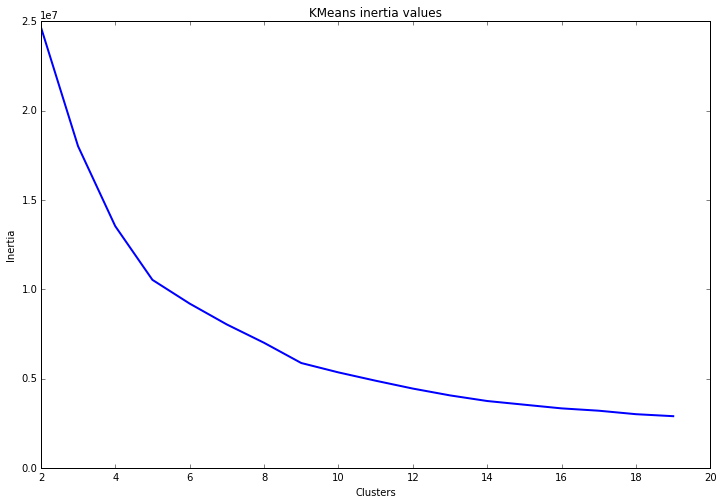

In [23]:
def test_clusters(range_n_clusters,fields=['X','Y','TimeOfDay','Year']):
    km_models = []
    i_scores = []
    tr = train_raw[fields].copy()
    tr = le.fit_transform(tr)
    for n_clusters in range(range_n_clusters):
        if n_clusters>1:
            km = KMeans(n_clusters=n_clusters, random_state=5)
            km.fit(tr)
            km_models.append(km)
            inertia = km.inertia_ 
            print 'For {0}, inertia = {1}'.format(
                n_clusters, inertia
            )
            i_scores.append(inertia)
       
    # plot results
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_title('KMeans inertia values')
    ax.set_xlabel('Clusters')
    ax.set_ylabel('Inertia')
    ax.plot([i for i in range(range_n_clusters) if i>1],i_scores,'-', linewidth=2)
    plt.show()
    
test_clusters(25)

In [24]:
# Reload data in case of changes
le = MultiColumnLabelEncoder()
tr = train_raw[['X','Y','TimeOfDay','Year']].copy()
tr = le.fit_transform(tr)

# Set k
k = 20

# Initialize Kmeans model
km = KMeans(n_clusters=k)
train_raw['KMcluster'] = km.fit_predict(tr)

# Calculate distances
distances = km.transform(tr)
train_raw['KMdistance'] = np.argmin(distances,axis=1)

# Predict for test dataset
tr = test_raw[['X','Y','TimeOfDay','Year']].copy()
tr = le.transform(tr)
test_raw['KMcluster'] = km.predict(tr)
distances = km.transform(tr)
test_raw['KMdistance'] = np.argmin(distances,axis=1)

In [25]:
g = train_raw.groupby('KMcluster')
g['KMcluster'].agg(len)

KMcluster
0     39737
1     69002
2     51555
3     53085
4     47612
5     37002
6     40421
7     40876
8        67
9     63555
10    26065
11    54460
12    33911
13    44950
14    41401
15    58841
16    42248
17    47120
18    45654
19    40487
Name: KMcluster, dtype: int32

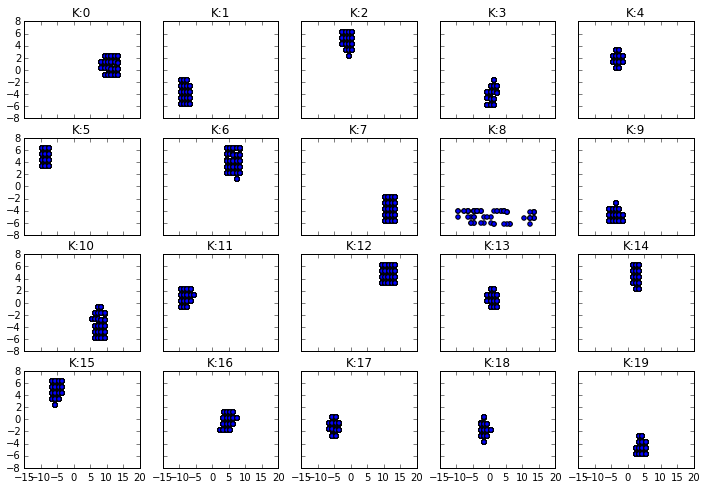

In [27]:
def plot_clusters():
    f, axarr = plt.subplots(4, 5, sharex=True, sharey=True)
    le = MultiColumnLabelEncoder()
    tr = train_raw[['X','Y','TimeOfDay','Year']].copy()
    tr = le.fit_transform(tr)
    pca = PCA(n_components=2)
    X = pca.fit_transform(tr)
    K = np.array(train_raw['KMcluster'])
    for i in range(20):
        if i<5: e=0
        elif i<10: e=1
        elif i<15: e=2
        else: e=3
        z = i - 5*e
        axarr[e, z].scatter(X[K==i,0]\
                            ,X[K==i,1]\
                            )
        axarr[e, z].set_title('K:{}'.format(i))
        plt.setp([a.get_xticklabels() for a in axarr[0, :]], visible=False)
        plt.setp([a.get_yticklabels() for a in axarr[:, 1]], visible=False)

plot_clusters()

In [ ]:
def predict_metaclass():
    '''Predict the metaclass of crime
       Use the outputted algorithm to 
       predict metaclass in the training data
    '''
    tr = sample_df(train_raw,'Category',set(train_raw['Category']),\
                                      group_n=200000)
    
    new_fields = [
        'PdDistrict','DaySegment','DayOfWeek',\
        'DayOfMonth','Year','KMcluster','KMdistance'
    ]
    cat_fields = [
        'PdDistrict','DayOfWeek','DaySegment','TimeOfDay',\
        'DayOfMonth','Year','KMcluster','collar_id'
    ]
    dev_train, dev_train_labels = tr[new_fields][5001:],\
                           tr['collar_id'][5001:]
    dev_test, dev_test_labels = tr[new_fields][:5000],\
                            tr['collar_id'][:5000]
    
    # Create pipeline
    le = MultiColumnLabelEncoder()
    cf = [i for i,x in enumerate(new_fields) if x in cat_fields]
    ohe = OneHotEncoder(categorical_features=cf,sparse=True)
    #md = MultinomialNB(alpha=0.01)
    md = LogisticRegression()
    pl = Pipeline([('le',le),('ohe',ohe),('md',md)])
    
    '''
    param_grid = dict(md__C=[0.1,1,1000])
    gs = GridSearchCV(pl, param_grid=param_grid, verbose=10)
    gs.fit(dev_train, dev_train_labels)
    print gs.best_estimator_ 
    '''
    
    # Fit training data 
    pl.fit(dev_train, dev_train_labels)
    
    # Show results
    print 'Accuracy: {}%'.format(round(pl.score(dev_test, \
                                                 dev_test_labels),4)*100)
    predictions = pl.predict(dev_test)
    conf = confusion_matrix(dev_test_labels,predictions)
    plt.imshow(conf, cmap='binary')
    print pd.crosstab(dev_test_labels, predictions, \
                      rownames=['True'], colnames=['Predicted'], \
                      margins=True)
    
    # Return model for later use
    '''
    return pl
    

pl_metaclass = predict_metaclass()

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] md__C=0.1 .......................................................

##### Get data from other sources

SF OpenData has a ton of supplemental data sources that will be great to try out for this effort.  

In [ ]:
# http://spatialreference.org/ref/epsg/2227/
p = Proj('+proj=lcc +init=EPSG:2227 +datum=NAD83 +units=us-ft +no_defs',preserve_units=True)
convert_vals = np.vectorize(lambda x,y: p(x,y))
convert_vals_inv = np.vectorize(lambda x,y: p(x,y,inverse=True))

In [ ]:
shpfilename_elect = 'Data/SanFranciscoElectricityUse/SanFranciscoElectricityUse.shp'
shpfilename_school = 'Data/schools_public_pt/schools_public_pt.shp'
shpfilename_zoning = 'Data/Zoning/Zoning_Districts.shp'

##### Process shapefiles

In [ ]:
# Convert lat/lon to coordinates that match shp
train_raw['New_X'], train_raw['New_Y'] = \
    convert_vals(train_raw['X'],train_raw['Y'])

test_raw['New_X'], test_raw['New_Y'] = \
    convert_vals(test_raw['X'],test_raw['Y'])

In [ ]:
def make_points(x):
    ''' Create list of Points objects
    '''
    out = []
    n = x.shape[0]
    for i in range(n):
        out.append(Point((x['New_X'][i],x['New_Y'][i])))
    return out
points = make_points(train_raw[['New_X','New_Y']])
test_points = make_points(test_raw[['New_X','New_Y']])

In [ ]:
shp = fiona.open(shpfilename_school)
n = len(shp)
SCHOOL_TYP,\
DEPT,\
FACILITY_N,\
DEPTNAME,\
FACILITY_I = \
    np.empty(n,dtype='|S25'),\
    np.empty(n,dtype='|S25'),\
    np.empty(n,dtype='|S25'),\
    np.empty(n,dtype='|S25'),\
    np.empty(n,dtype='|S25')
for i,s in enumerate(shp):
    SCHOOL_TYP[i] = s['properties']['SCHOOL_TYP']
    DEPT [i] = s['properties']['DEPT']
    FACILITY_N [i] = s['properties']['FACILITY_N']
    DEPTNAME [i] = s['properties']['DEPTNAME']
    FACILITY_I [i] = s['properties']['FACILITY_I']
shp.close()

props_df = pd.DataFrame({
        'Id':[i+1 for i in range(n)],
        'SCHOOL_TYP':SCHOOL_TYP
    })

In [ ]:
set(props_df['SCHOOL_TYP'])

In [ ]:
hs = props_df[props_df['SCHOOL_TYP']=='High School']['Id']
cs = props_df[props_df['SCHOOL_TYP']=='County School']['Id']
chs = props_df[props_df['SCHOOL_TYP']=='Charter School']['Id']
ms = props_df[props_df['SCHOOL_TYP']=='Middle School']['Id']

In [ ]:
def coord_search_schools(pts):
    ''' Find nearest point and measure distance
        for every datapoint 
    '''
    shp = pysal.open(shpfilename_school,'r')
    pl_hs = BruteForcePointLocator([p for p in shp if p.id in hs])
    pl_cs = BruteForcePointLocator([p for p in shp if p.id in cs])
    pl_chs = BruteForcePointLocator([p for p in shp if p.id in chs])
    pl_ms = BruteForcePointLocator([p for p in shp if p.id in ms])
    shp.close()

    return_point_hs = lambda x: pl_hs.nearest(x)
    return_point_cs = lambda x: pl_cs.nearest(x)
    return_point_chs = lambda x: pl_chs.nearest(x)
    return_point_ms = lambda x: pl_ms.nearest(x)
    
    # point_ids = np.zeros(len(points),dtype=np.int8)
    point_distances_hs = np.zeros(len(pts),dtype=np.float64)
    point_distances_cs = np.zeros(len(pts),dtype=np.float64)
    point_distances_chs = np.zeros(len(pts),dtype=np.float64)
    point_distances_ms = np.zeros(len(pts),dtype=np.float64)
    
    def run_iters():
        for i,p in enumerate(points):
            if i%100000==0: print 'running {0} row'.format(i)
            pt_hs = return_point_hs(p)
            pt_cs = return_point_cs(p)
            pt_chs = return_point_chs(p)
            pt_ms = return_point_ms(p)
            
            point_distances_hs[i] = arcdist(p,pt_hs)
            point_distances_cs[i] = arcdist(p,pt_cs)
            point_distances_chs[i] = arcdist(p,pt_chs)
            point_distances_ms[i] = arcdist(p,pt_ms)

    run_iters()
    
    return point_distances_hs,\
            point_distances_cs,\
            point_distances_chs,\
            point_distances_ms

In [ ]:
# This runs relatively quickly 
#point_distances_hs,\
#            point_distances_cs,\
#            point_distances_chs,\
#            point_distances_ms = coord_search_schools(points)

In [ ]:
# test_point_distances_hs,\
#            test_point_distances_cs,\
#            test_point_distances_chs,\
#            test_point_distances_ms = coord_search_schools(test_points)

In [ ]:
def run_iters_elect(plocator,return_poly_id,pts,test):
    poly_ids = np.zeros(len(pts),dtype=np.int8)
    for i,p in enumerate(pts):
        if i%100000==0: print 'running {0} row'.format(i)
        poly_ids[i] = return_poly_id(plocator,p)
    # Save data because this step takes >5hrs to finish
    if test: outname = 'Data/test_poly_ids2.csv'
    else: outname = 'Data/poly_ids2.csv'
    poly_ids_df = pd.DataFrame({'elect_poly_id':poly_ids})
    poly_ids_df.to_csv(outname,index=False)

def run_iters_zoning(plocator,return_poly_id,pts,test):
    poly_ids = np.zeros(len(pts),dtype=np.int8)
    for i,p in enumerate(pts):
        if i%1==100000: print 'running {0} row'.format(i)
        poly_ids[i] = return_poly_id(plocator,p)
    # Save data because this step takes >5hrs to finish
    if test: outname = 'Data/test_zoning_ids2.csv'
    else: outname = 'Data/zoning_ids2.csv'
    poly_ids_df = pd.DataFrame({'zoning_id':poly_ids})
    poly_ids_df.to_csv(outname,index=False)

def return_poly_id(pl,x):
        ''' Find the polygon that 
            contains each point
        '''
        try:
            return pl.contains_point(x)[0].id
        except IndexError:
            return -1

def polygon_search(shpfilename,run_iters,\
                   pts,test=False,\
                   return_poly_id=return_poly_id):
    ''' Iterate through shapefile polygons
        and find id of polgy for each datapoint
    '''
    shp = pysal.open(shpfilename,'r')
    pl = PolygonLocator([p for p in shp])
    shp.close()
    run_iters(pl,return_poly_id,pts,test)

polygon_search(shpfilename_elect,run_iters_elect,test_points,test=True)
polygon_search(shpfilename_zoning,run_iters_zoning,test=True)

In [ ]:
# only run this after ids are compiled
poly_ids_df_elect = pd.read_csv('Data/poly_ids2.csv')
test_poly_ids_df_elect = pd.read_csv('Data/test_poly_ids2.csv')

In [ ]:
def run_iters(points, point_locator, centroids, \
              log_at=100000):
    ''' Iterate through points to find 
        the nearest centroid from shapefile
    '''
    point_fun = lambda x,pl: pl.nearest(x)
    id_fun = lambda p, centroids: [i for i,c in enumerate(centroids)\
                                  if c==p][0]
    nearest_ids = np.zeros(len(points),dtype=np.int64)
    for i,p in enumerate(points):
        if i%log_at==0: print 'running {0} row'.format(i)
        pt = point_fun(p,point_locator)
        pt_id = id_fun(pt, centroids)
        nearest_ids[i] = pt_id
    return nearest_ids

def save_file(array_to_save, colname, filename):
    ''' Write column to CSV '''
    array_to_save_df = pd.DataFrame({colname:array_to_save})
    array_to_save_df.to_csv(filename,index=False)

def coord_search(shpfile, points, \
                 run_iters_fun, \
                 locator_fun=BruteForcePointLocator):
    ''' Since polygon search is not efficient
        do a comparison to each centroid instead
    '''
    gather_centroids = lambda shp: [p.centroid for p in shp]

    # Read file
    shp = pysal.open(shpfile,'r')
    centroids = gather_centroids(shp)
    pl = locator_fun(centroids)
    shp.close()
    
    # Return the nearest points
    nearest_ids = run_iters_fun(points,pl,centroids)
    
    return nearest_ids

zone_ids = coord_search(shpfilename_zoning,points,\
                        run_iters)
save_file(zone_ids, 'zoning_id', 'Data/zoning_ids2.csv')
test_zone_ids = coord_search(shpfilename_zoning,test_points,\
                         run_iters)
save_file(test_zone_ids, 'zoning_id', 'Data/test_zoning_ids2.csv')

In [ ]:
# only run this after zone ids are compiled
zone_ids = pd.read_csv('Data/zoning_ids2.csv')
test_zone_ids = pd.read_csv('Data/test_zoning_ids2.csv')

In [ ]:
shp = fiona.open(shpfilename_zoning)
n = len(shp)
ZONING_SIM,\
DISTRICTNA = \
    np.empty(n,dtype='|S25'),\
    np.empty(n,dtype='|S25')
for i,s in enumerate(shp):
    ZONING_SIM[i] = s['properties']['ZONING_SIM']
    DISTRICTNA[i] = s['properties']['DISTRICTNA']
shp.close()

props_df_zoning = pd.DataFrame({
        'Id':[i+1 for i in range(n)],
        'ZONING_SIM':ZONING_SIM,
        'DISTRICTNA':DISTRICTNA
    })
all_zones = pd.merge(zone_ids,props_df_zoning,'left',\
                    left_on=['zoning_id'], right_on=['Id'])
test_all_zones = pd.merge(test_zone_ids,props_df_zoning,'left',\
                    left_on=['zoning_id'], right_on=['Id'])

In [ ]:
shp = fiona.open(shpfilename_elect)
n = len(shp)
kWh_pC,\
kWh,\
Zip,\
Pop2010_zc = \
    np.empty(n,dtype=np.float64),\
    np.empty(n,dtype=np.float64),\
    np.empty(n,dtype='|S10'),\
    np.empty(n,dtype=np.int64)
for i,s in enumerate(shp):
    kWh_pC[i] = s['properties']['kWh_pC']
    kWh [i] = s['properties']['kWh']
    Zip [i] = s['properties']['Zip']
    Pop2010_zc [i] = s['properties']['Pop2010_zc']
shp.close()

props_df_elect = pd.DataFrame({
        'Id':[i+1 for i in range(n)],\
        'kWh_pC':kWh_pC,\
        'kWh':kWh,\
        'Zip':Zip,\
        'Pop2010_zc':Pop2010_zc\
    })
all_elects = pd.merge(poly_ids_df_elect, props_df_elect, 'left',\
                     left_on=['elect_poly_id'], right_on=['Id'])
test_elects = pd.merge(test_poly_ids_df_elect, props_df_elect, 'left',\
                     left_on=['elect_poly_id'], right_on=['Id'])

##### Add new columns

In [ ]:
elect_cols = ['kWh_pC','kWh','Zip','Pop2010_zc']
train_raw[elect_cols] = all_elects[elect_cols] 
test_raw[elect_cols] = test_elects[elect_cols] 

In [ ]:
# School features had little/no effect on the model
# school_nearby = np.vectorize(lambda x: True if x<=1000 else False)
# train_raw['HS_DISTANCE'] = point_distances_hs.astype(np.float64)
# train_raw['CS_DISTANCE'] = point_distances_cs.astype(np.float64)
# train_raw['CHS_DISTANCE'] = point_distances_chs.astype(np.float64)
# train_raw['MS_DISTANCE'] = point_distances_ms.astype(np.float64)
# train_raw['HS_NEARBY'] = school_nearby(train_raw['HS_DISTANCE'])
# train_raw['CS_NEARBY'] = school_nearby(train_raw['CS_DISTANCE'])
# train_raw['CHS_NEARBY'] = school_nearby(train_raw['CHS_DISTANCE'])
# train_raw['MS_NEARBY'] = school_nearby(train_raw['MS_DISTANCE'])

# test_raw['HS_DISTANCE'] = test_point_distances_hs.astype(np.float64)
# test_raw['CS_DISTANCE'] = test_point_distances_cs.astype(np.float64)
# test_raw['CHS_DISTANCE'] = test_point_distances_chs.astype(np.float64)
# test_raw['MS_DISTANCE'] = test_point_distances_ms.astype(np.float64)
# test_raw['HS_NEARBY'] = school_nearby(test_raw['HS_DISTANCE'])
# test_raw['CS_NEARBY'] = school_nearby(test_raw['CS_DISTANCE'])
# test_raw['CHS_NEARBY'] = school_nearby(test_raw['CHS_DISTANCE'])
# test_raw['MS_NEARBY'] = school_nearby(test_raw['MS_DISTANCE'])

In [ ]:
train_raw['ZONING_SIM'] = all_zones['ZONING_SIM']
train_raw['DISTRICT_NAME'] = all_zones['DISTRICTNA']
train_raw['ZONE_ID'] = all_zones['Id']

test_raw['ZONING_SIM'] = test_all_zones['ZONING_SIM']
test_raw['DISTRICT_NAME'] = test_all_zones['DISTRICTNA']
test_raw['ZONE_ID'] = test_all_zones['Id']

##### Test performance

In [ ]:
new_fields = [
    'PdDistrict','DaySegment',\
    'kWh','Zip','Pop2010_zc','Year','KMcluster'
]
cat_fields = [
    'PdDistrict','DayOfWeek','DaySegment','TimeOfDay','DayOfMonth','Year',\
    'Zip','KMcluster',\
    'ZONING_SIM','DISTRICT_NAME','ZONE_ID'
]
train_raw = train_raw.iloc[\
                    np.random.permutation(len(train_raw))]
dev_train, dev_train_labels = train_raw[new_fields][10001:],\
                        train_raw['Category'][10001:]
dev_train_weights = np.array(train_raw['sample_weight'][10001:])
dev_test, dev_test_labels = train_raw[new_fields][:10000],\
                        train_raw['Category'][:10000]

In [ ]:
def add_knnguess():
    knn = KNeighborsClassifier(n_neighbors=20)
    le = MultiColumnLabelEncoder()
    imp = Imputer(strategy='mean')
    cf = [i for i,x in enumerate(new_fields) if x in cat_fields]
    ohe = OneHotEncoder(categorical_features=cf,sparse=False)
    pca = PCA(n_components = 20)

    pl = Pipeline([('le',le), ('imp',imp), ('ohe', ohe), ('pca',pca), ('knn', knn)])
    pl.fit(dev_train, dev_train_labels)
    train_raw['KNNguess'] = pl.predict(train_raw[new_fields])
    test_raw['KNNguess'] = pl.predict(test_raw[new_fields])

add_knnguess()

In [ ]:
def runmodel(n=100):
    new_fields = [
        'PdDistrict','DaySegment',\
        'kWh','Zip','Pop2010_zc','Year','KMcluster'
    ]
    cat_fields = [
        'PdDistrict','DayOfWeek','DaySegment','TimeOfDay','DayOfMonth','Year',\
        'Zip','KMcluster',\
        'ZONING_SIM','DISTRICT_NAME','ZONE_ID','KNNguess'
    ]

    le = MultiColumnLabelEncoder()
    imp = Imputer(strategy='mean')
    cf = [i for i,x in enumerate(new_fields) if x in cat_fields]
    ohe = OneHotEncoder(categorical_features=cf,sparse=False)
    rf = RandomForestClassifier(n_jobs=2, n_estimators=n) 
    pca = PCA(n_components = 20)

    pl = Pipeline([('le',le), ('imp',imp), ('ohe', ohe), ('pca',pca), ('rf', rf)])
    pl.fit(dev_train, dev_train_labels,rf__sample_weight=dev_train_weights)
    print 'Accuracy: {0}%'.format(round(pl.score(dev_test, dev_test_labels),4)*100)
    return pl 

# pl = runmodel(300)

In [ ]:
def show_pca():
    exp_var = np.cumsum(pl.named_steps['pca'].explained_variance_ratio_)
    n = len(exp_var)

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_title('PCA explained variance')
    ax.set_xlabel('Feature number')
    ax.set_ylabel('Explained Variance')
    ax.plot(range(n),exp_var,'-', linewidth=2)

    plt.show()

# show_pca()

##### Make another submission

In [ ]:
def save_testdata():
    test_raw.to_csv('Data/test_raw_nf.csv',index=False)

# save_testdata()

In [ ]:
# predictions = pl.predict(test_raw[new_fields])

In [ ]:
def write_to_submissionfile():
    l = len(test_raw)
    submission = np.zeros((l,40),dtype=np.int32)
    submission[:,0] = range(l)
    cols = sorted(set(train_raw['Category']))
    for i,c in enumerate(cols):
        submission[:,i+1] = predictions == c

    submission_cols = ['Id']
    submission_cols.extend(cols)
    submission_df = pd.DataFrame(submission,columns=submission_cols)
    submission_df.head()

    submission_df.to_csv('Data/submission_file2.csv',index=False)
    
# write_to_submissionfile()

#### Part 3 - Error Diagnosis

In [ ]:
predictions = pl.predict(dev_test)
conf = confusion_matrix(dev_test_labels,predictions)
plt.imshow(conf, cmap='binary')
pd.crosstab(dev_test_labels, predictions, rownames=['True'], colnames=['Predicted'], margins=True)